---
title: "MNIST Digit Classifier"
author: "Seongbin Park"
jupyter: "python3"
categories: [ml, projects, kaggle-competition]
format:
  html:
    toc: true
page-layout: article
description: How to build a (very) simple neural network for MNIST digit classification
date: "2022-08-05"
---

This post will cover how to classify handwritten digits of the MNIST dataset using a simple neural network. At the same time, I will be taking a stab at the [Kaggle Digit Recognizer](https://www.kaggle.com/competitions/digit-recognizer/overview) contest.

Credits: I will be working off of chapter 4 of the [fast.ai](https://github.com/fastai/fastbook) book, which covers binary classification of 3's and 7's. Other resources are linked.

In [1]:
# |code-fold: true
# |code-summary: required libraries

from fastai.vision.all import *

## Dowloading the Data
First, we will have to import the MNIST dataset itself. We can import it using the fast.ai library (`path = untar_data(URLs.MNIST)`), but I will download the dataset from [kaggle](https://www.kaggle.com/competitions/digit-recognizer/) instead.

If you are following along and haven't set up the kaggle API yet, do so by following along the README of the official [repo](https://github.com/Kaggle/kaggle-api). You will need an account to do so. After everything is set up, we can run the following code block:

In [2]:
!kaggle competitions download -c digit-recognizer

  0%|                                               | 0.00/15.3M [00:00<?, ?B/s]
100%|███████████████████████████████████████| 15.3M/15.3M [00:00<00:00, 161MB/s]


Note that in Jupyter notebooks, the exclamation mark ! is used to execute shell commands. The dataset should be downloaded in your project directory as a zip file. Run the following code block to extract the contents to a file named MNIST_dataset:

In [3]:
!unzip digit-recognizer.zip -d MNIST_dataset

Archive:  digit-recognizer.zip
  inflating: MNIST_dataset/sample_submission.csv  
  inflating: MNIST_dataset/test.csv  
  inflating: MNIST_dataset/train.csv  


Let's take a look at `test.csv` (the test set) and `train.csv` (the training set):

In [4]:
ds_path = Path("./MNIST_dataset")

In [5]:
# test.csv
df_test = pd.read_csv(ds_path/"test.csv")
df_test.head(3)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# train.csv
df_train = pd.read_csv(ds_path/"train.csv")
df_train.head(3)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now that we downloaded the data, we need to shape it for training and validating.

## Shaping the Data

To train our model, we need to separate and normalize the independent (pixels) and dependent (label) variables. The labels will be represented using [one hot encoding](https://en.wikipedia.org/wiki/One-hot).

In [7]:
X_train = tensor(df_train.drop(labels = ['label'],axis = 1)) / 255.0

In [8]:
y_train_numeric = df_train['label']

rows = np.arange(y_train_numeric.size)
y_train = tensor(np.zeros((y_train_numeric.size, 10)))
y_train[rows, y_train_numeric] = 1

X_train.shape, y_train.shape

(torch.Size([42000, 784]), torch.Size([42000, 10]))

`X_train.shape` and `y_train.shape` tells us that we have 42000 digits in our dataset, with each digit having 784 pixels. We will use tensors to take advantage of faster GPU computations.

We want to create a Pytorch [`Dataset`](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html), which is required to return a tuple of `(x,y)` when indexed. Python provides a [`zip`](https://www.w3schools.com/python/ref_func_zip.asp) function which, when combined with [`list`](https://www.w3schools.com/python/ref_func_list.asp), can do this easily:

In [9]:
# |output: false

ds = list(zip(X_train,y_train))
ds[0]
# output removed for readability

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0

Next, we want to split our dataset `ds` into a training and validation set:

In [10]:
train, val = torch.utils.data.random_split(ds,[32000, 10000])

Later, we will be using stochastic gradient descent, which requires that we have "mini-batches" of our dataset. We can create a `DataLoader` from our `train` dataset to do so:

In [11]:
dl = DataLoader(train, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 10]))

We can do the same for our validation (`val`) dataset:

In [12]:
valid_dl = DataLoader(val, batch_size=256)

## Training a Linear Model

Now that our data is ready, we can start training our classification model. We will start with a linear model, then add some non-linearity to it!

First, we must randomly initialize the bias and all weights for each pixel. Since we have 10 labels (one for each digit), there must be 10 outputs, so our weights matrix is of size `784x10`.

In [13]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

weights = init_params((784,10))
bias = init_params(1)

The prediction given a tensor `x` is

$$\text{prediction} = x \cdot \text{weights} + \text{bias}.$$

In [14]:
def linear1(xb): return xb@weights + bias

To calculate a gradient, we need a loss function. Since there are more than 2 labels, we will use [cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html), which is related to the [softmax](https://developers.google.com/machine-learning/crash-course/multi-class-neural-networks/softmax) function instead of a sigmoid function (which is used for binary classification).

In [15]:
def mnist_loss(xb, yb):
    loss = nn.CrossEntropyLoss()
    return loss(xb, yb)

For testing and demonstration purposes, let's work with a smaller batch than the ones created when shaping our data.

In [16]:
batch = X_train[:4]
batch.shape

torch.Size([4, 784])

In [17]:
preds = linear1(batch)
preds

tensor([[ -0.5287,  12.6047,  -9.0290,  -1.7505,   3.7686,  18.8489,  -1.8141,
         -12.2232,  -5.1421,  -6.6316],
        [ 18.8942,  10.7898,   9.2573,   7.9989,  -1.2884,  19.0238,  -5.8788,
           6.5045, -10.2431,   5.5865],
        [  6.3639,  14.0687,   0.7705,  -1.3580,   1.4220,   7.3108,  -7.4359,
          -6.8101,  -5.9212,  23.7016],
        [-14.7847,   3.0711,  -0.6092,   2.2720,  -1.1361,   3.7617,   5.1197,
           5.3868,  -1.5228,  -7.6523]], grad_fn=<AddBackward0>)

In [18]:
loss = mnist_loss(preds, y_train[:4])
loss

tensor(5.9773, grad_fn=<DivBackward1>)

Now we can calculate the gradients:

In [19]:
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

(torch.Size([784, 10]), tensor(2.4328e-10), tensor([5.9605e-08]))

The following function combines the above code and generalizes to models other than `linear1`.

In [20]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [21]:
calc_grad(batch, y_train[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(4.8657e-10), tensor([1.1921e-07]))

Using the calculated gradients, we can update the weights for each epoch. We need to specify a learning rate and reset the gradients to 0, since `loss.backward` actually adds the gradients of loss to any gradients that are currently stored.
```Python
lr = 1.

for p in weights,bias:
    p.data -= p.grad*lr
    p.grad.zero_()
```

Finally, we can define a function that trains the model for one epoch:

In [22]:
def train_epoch(model, params, lr=1):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

We also probably want to check the accuracy of our model. The label that the model predicts is the label with the highest activation:

In [23]:
def batch_accuracy(xb, yb):
    label = torch.argmax(xb, dim=1)
    y_truth = torch.argmax(yb, dim=1)
    correct = y_truth == label
    return correct.float().mean()

In [24]:
batch_accuracy(linear1(batch), y_train[:4])

tensor(0.)

To get the accuracy for the whole epoch, we must call `batch_accuracy` with batches of the validation dataset, then take the mean over all batches.

In [25]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

Finally, we can see if our code works by checking if the accuracy improves!

In [26]:
params = weights, bias
for i in range(40):
    train_epoch(linear1, params)
    print(validate_epoch(linear1), end=' ')

0.8213 0.8532 0.8661 0.8736 0.8769 0.8808 0.8848 0.8869 0.8895 0.8914 0.8929 0.894 0.8949 0.8964 0.8973 0.8977 0.8978 0.8979 0.8981 0.8986 0.8998 0.9 0.9004 0.9016 0.9017 0.9027 0.9027 0.9032 0.9037 0.9047 0.9053 0.9058 0.9061 0.9062 0.9061 0.9062 0.906 0.9061 0.906 0.9063 

## Simplifying Code

`nn.Linear` does the same thing as our `init_params` and `linear1` functions together. Also, fastai's `SGD` class provides us with functions that takes care of updating the parameters and reseting the gradients of our model. By replacing some code, we can boil the training portion of our MNIST classifer down to the following:

In [27]:
def mnist_loss(xb, yb):
    loss = nn.CrossEntropyLoss()
    return loss(xb, yb)

def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

def train_epoch_simple(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()
        
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch_simple(model)
        print(validate_epoch(model), end=' ')
        
linear_model = nn.Linear(28*28,10)
opt = SGD(linear_model.parameters(), lr=1)
train_model(linear_model, 20)

0.8983 0.9057 0.9092 0.9113 0.9143 0.9149 0.9154 0.9154 0.9162 0.9161 0.9166 0.9167 0.9166 0.9166 0.9164 0.9169 0.917 0.9173 0.9173 0.9175 

Fast.ai provides us with `Learner.fit`, which we can use instead of `train_model` to significantly reduce the amount of code we need to write. To use the function, we must create a `Learner`, which requires a `DataLoaders` of our training and validation datasets:

In [28]:
dls = DataLoaders(dl, valid_dl)

Then, we pass in `DataLoaders`, the model, the optimization function, the loss function, and optionally any metrics to print into the `Learner` constructor to create one:

In [29]:
learn = Learner(dls, nn.Linear(28*28,10), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

Finally, we can call `Learner.fit`:

In [30]:
learn.fit(10, lr=1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.413918,0.365917,0.897400,00:00
1,0.326721,0.337396,0.905100,00:00
2,0.302027,0.325679,0.908500,00:00
3,0.289524,0.319092,0.910000,00:00
4,0.281248,0.314855,0.912800,00:00
5,0.275084,0.311911,0.913200,00:00
6,0.270192,0.309764,0.913500,00:00
7,0.266153,0.308146,0.913900,00:00
8,0.262723,0.306901,0.914300,00:00
9,0.259748,0.305928,0.914900,00:00


## Adding Non-linearity

To expand upon our model, we can add another layer on top of what we have now. However, mathematically speaking, the composition of two linear functions is another linear function. Therefore, stacking two linear classifiers on top of each other is equivalent to having just one linear classifier.

Therefore, we must add some non-linearity between linear layers. We often do this by through activation functions; a common one is the [`ReLU`](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/) function:

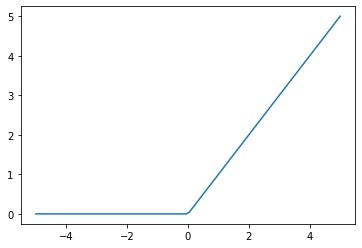

In [31]:
x = np.linspace(-5,5,100)
y = np.maximum(0, x)

plt.plot(x, y)

[`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) creates a module that will call each of the listed layers or functions.

Our first layer takes in 784 inputs (pixels) and outputs 60 numbers. Those 60 numbers are then each passed into the `ReLU` function before going into the second layer. The second layer has 10 outputs, which as before, is the probability of each digit being the lable.

In [32]:
simple_net = nn.Sequential(
    nn.Linear(784,100),
    nn.ReLU(),
    nn.Linear(100,10)
)

We can train this model using `Learner.fit` as well (we are using more epochs and smaller learning rate, since it is a larger model):

In [33]:
# |output: false
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)
learn.fit(60, lr=0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.781461,0.532242,0.866300,00:00
1,0.441000,0.395819,0.893000,00:00
2,0.355962,0.352042,0.902600,00:00
3,0.319263,0.327102,0.909500,00:00
4,0.295532,0.308874,0.913600,00:00
5,0.276869,0.293574,0.917000,00:00
6,0.261044,0.280591,0.920400,00:00
7,0.247288,0.268860,0.924300,00:00
8,0.235076,0.258463,0.927900,00:00
9,0.223990,0.248834,0.930800,00:00


The output is ommitted to save room; the training process is recorded in `learn.recorder`, with the table of output stored in the `values` attribute, so we can plot the accuracy over training as:

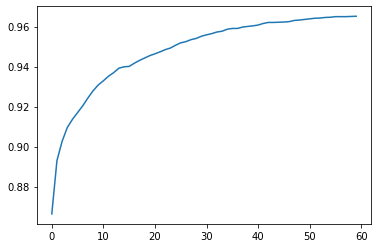

In [34]:
plt.plot(L(learn.recorder.values).itemgot(2))

In [35]:
# final accuracy
learn.recorder.values[-1][2]

0.9652000069618225

## Making a Submission

Though our very basic model is far from perfect, we can still submit it to the competition! Recall that we stored the test.csv data into the df_test `DataFrame`. We need to first normalize the pixels then plug it into our model:

In [36]:
X_test = tensor(df_test)/ 255.0

In [37]:
x_val = simple_net(X_test)
y_pred = torch.argmax(x_val, dim=1)
y_pred = y_pred.tolist()

Finally, we can create a submission file in our current directory:

In [38]:
with open("submission.csv", 'w+') as f :
    f.write('ImageId,Label\n')
    for i in range(len(y_pred)) :
        f.write("".join([str(i+1),',',str(y_pred[i]),'\n']))

Then submit to Kaggle!

In [39]:
!kaggle competitions submit -c digit-recognizer -f submission.csv -m "First Attempt"

100%|█████████████████████████████████████████| 208k/208k [00:01<00:00, 165kB/s]
Successfully submitted to Digit Recognizer